In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
import seaborn as sns; sns.set(color_codes=True)
import cupy as cp
import rapids_singlecell as rsc
import stlearn as st
import monkeybread as mb
from matplotlib.colors import to_hex
from matplotlib import cm
import os

import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata
def convertTMAName(name):
    row, col = name.split('-')
    row = ord(row)-ord('A')+1
    col = chr(int(col)+64)
    return (col+str(row))
def plot_stacked_bar(list_of_lists, analysis_type, group_names, title_name, dir=None):
    # Flatten the list of lists
    flattened_list = [item for sublist in list_of_lists for item in sublist]

    # Get the unique phenotypes
    unique_phenotypes = list(set(flattened_list))

    # Create a dictionary to store the counts
    phenotype_counts = {phenotype: [0] * len(group_names) for phenotype in unique_phenotypes}

    # Count the occurrences of each phenotype for each group
    for i, group_list in enumerate(list_of_lists):
        for phenotype in group_list:
            phenotype_counts[phenotype][i] += 1

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(phenotype_counts, orient='index')
    df.columns = group_names

    # Normalize the counts for each group
    normalized_df = df.div(df.sum(axis=0), axis=1) * 100

    # Plot the stacked bar chart
    normalized_df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 5))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.xlabel(analysis_type)
    plt.xticks(rotation=45)
    plt.ylabel("% Cell Types")
    plt.title(title_name + ' Cell Type Proportions by Niches')
    if dir:
        plt.savefig(os.path.join(dir, title_name+'_nicheprop.png'),bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
adata_C = ad.read_h5ad('adata_C_batched.h5ad')

adata_C.obsm['X_pca'] = adata_C.obsm['X_pca_harmony']
rsc.pp.neighbors(adata_C, n_neighbors=30, n_pcs=29, use_rep='X_pca')
rsc.tl.umap(adata_C)
rsc.tl.leiden(adata_C, resolution=0.5)
sc.pl.umap(adata_C, color=['leiden'], size=3)
sc.pl.umap(adata_C, color=['batch'], size=3)

st.pp.scale(adata_C)
sc.pl.dotplot(adata_C, adata_C.var_names.to_list(), groupby='leiden', dendrogram=False, log=True, cmap='RdBu_r')

In [ ]:
adata_N = ad.read_h5ad('adata_N_batched.h5ad')

adata_N.obsm['X_pca'] = adata_N.obsm['X_pca_harmony']
rsc.pp.neighbors(adata_N, n_neighbors=30, n_pcs=29, use_rep='X_pca')
rsc.tl.umap(adata_N)
rsc.tl.leiden(adata_N, resolution=0.5)
sc.pl.umap(adata_N, color=['leiden'], size=3)
sc.pl.umap(adata_N, color=['batch'], size=3)

st.pp.scale(adata_N)
sc.pl.dotplot(adata_N, adata_N.var_names.to_list(), groupby='leiden', dendrogram=False)

In [ ]:
# Anand cell type annotations
cellTypes_Anand = ['Tumor', 'Macrophage', 'Epithelium', 'Tumor', 'Tumor', 'Tumor', 'Endothelium', 'VIM+ COLIV+ Stroma', 'Tumor', 'Tumor',
                  'Macrophage', 'Dendritic Cell', 'CD8 T Cell', 'VIM+ COLIV+ Stroma', 'B Cell']
adata_C.obs['cellType'] = ''
adata_C.obs['cellType'] = adata_C.obs['cellType'].astype(str)

i = 0
for c in np.sort(adata_C.obs['leiden'].astype(int).unique()):
    adata_C.obs.loc[adata_C.obs['leiden'] == str(c), 'cellType'] = cellTypes_Anand[i]
    i = i+1

# Generate a sufficient number of distinct colors using seaborn's color palette
num_colors = len(np.unique(cellTypes_Anand))
palette = sns.color_palette("colorblind", num_colors)

# Convert colors to hex
cell_type_colors = {cell_type: to_hex(palette[i]) for i, cell_type in enumerate(np.unique(cellTypes_Anand))}

# Add colors to AnnData object
adata_C.uns['cellType_colors'] = [cell_type_colors[ct] for ct in adata_C.obs['cellType'].unique()]

# Plot UMAP with custom colors
sc.pl.umap(adata_C, color='cellType', size=3)
sc.pl.dotplot(adata_C, adata_C.var_names.to_list(), groupby='cellType', dendrogram=False, log=True, cmap='RdBu_r')

In [ ]:
cellTypes_C = ['Neuroendocrine Tumor', 'Epithelial', 'Neuroendocrine', 'Neuroendocrine Tumor',
                'Neuroendocrine', 'Neuroendocrine Tumor', 'Vasculature/Endothelial', 'Mesenchymal Stem',
                'Neuroendocrine', 'Neuroendocrine', 'Macrophage', 'CD4 T', 'CD8 T',
                'VIM+, COL4+ Stroma', 'Dendritic']
cellTypes_N = ['Neuroendocrine', 'Activate T Lymphocyte', 'Progenitor', 'CD4 T', 'Mesenchymal',
               'Macrophage', 'Proliferating B Lymphocyte', 'CD8 T', 'B Lymphocyte', 'Activated T Lymphocyte',
               'Smooth Muscle', 'Endothelial', 'Epithelial/ECM', 'Macrophage/Dendritic', 'Neuroendocrine',
               'Macrophage', 'Neuroendocrine', 'Proliferating Epithelial', 'Neuroendocrine', 'Macrophage',
               'ECM', 'Epithelial']

# cancer
adata_C.obs['cellType'] = ''
adata_C.obs['cellType'] = adata_C.obs['cellType'].astype(str)

i = 0
for c in np.sort(adata_C.obs['leiden'].astype(int).unique()):
    adata_C.obs.loc[adata_C.obs['leiden'] == str(c), 'cellType'] = cellTypes_C[i]
    i = i+1

sc.pl.umap(adata_C, color=['cellType'], size=3)
sc.pl.dotplot(adata_C, adata_C.var_names.to_list(), groupby='cellType', dendrogram=False, cmap='viridis')

# normal
adata_N.obs['cellType'] = ''
adata_N.obs['cellType'] = adata_N.obs['cellType'].astype(str)

i = 0
for c in np.sort(adata_N.obs['leiden'].astype(int).unique()):
    adata_N.obs.loc[adata_N.obs['leiden'] == str(c), 'cellType'] = cellTypes_N[i]
    i = i+1

sc.pl.umap(adata_N, color=['cellType'], size=3)
sc.pl.dotplot(adata_N, adata_N.var_names.to_list(), groupby='cellType', dendrogram=False, cmap='viridis')

In [ ]:
gene_expr = adata_C.X
gene_names = adata_C.var_names

# Calculate the correlation matrix
corr_matrix = np.corrcoef(gene_expr.T)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=gene_names, yticklabels=gene_names, vmax=1, vmin=-1, square=True, cmap="coolwarm", annot=False, ax=ax)
ax.set_title('Correlation Matrix for Cancer Cells')
plt.show()

gene_expr = adata_N.X
gene_names = adata_N.var_names

# Calculate the correlation matrix
corr_matrix = np.corrcoef(gene_expr.T)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=gene_names, yticklabels=gene_names, vmax=1, vmin=-1, square=True, cmap="coolwarm", annot=False, ax=ax)
ax.set_title('Correlation Matrix for Normal Cells')
plt.show()

In [ ]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

adata = ad.concat([adata_C, adata_N])

# Create a list of TMA positions
'''rows = [chr(i) for i in range(ord('A'), ord('O') + 1)]
cols = range(1, 8)
all_positions = [f'{r}-{c}' for r in rows for c in cols]'''

rows = range(1, 16)
cols = [chr(i) for i in range(ord('A'), ord('G') + 1)]
all_positions = [f'{c}{r}' for r in rows for c in cols]

# Get the unique TMAs from the data
TMAs = adata.obs['batch'].unique()

# Create the figure and axes
fig, axes = plt.subplots(nrows=15, ncols=7, figsize=(20, 40))

# Plot each TMA in the correct position, leaving blanks for missing TMAs
for pos, ax in zip(all_positions, axes.flat):
    if pos in TMAs:
        sc.pl.embedding(adata[adata.obs['batch'] == pos], basis='spatial', color='leiden', ax=ax, show=False, size=15)
        ax.set_title(f'{pos}')
    else:
        ax.set_facecolor('white')  # Set blank background for missing TMAs
        ax.axis('off')  # Remove axes for missing TMAs
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Hide any remaining subplots that aren't used
for ax in axes.flat[len(all_positions):]:
    ax.axis('off')

# Create a new axis for the legend
legend_ax = fig.add_axes([0.96, 0.1, 0.04, 0.8])
legend_ax.axis('off')

# Check if any subplot has a legend
first_non_empty_plot = next((ax for ax in axes.flat if ax.get_legend()), None)
if first_non_empty_plot:
    legend_handles, legend_labels = first_non_empty_plot.get_legend_handles_labels()

    # Create the legend in the new axis
    legend_ax.legend(legend_handles, legend_labels, loc='center')

# Set the overall title and layout
# fig.suptitle('Neuro TMA Leiden Clustering', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

# Create a list of TMA positions
rows = range(1, 16)
cols = [chr(i) for i in range(ord('A'), ord('G') + 1)]
all_positions = [f'{c}{r}' for r in rows for c in cols]

# Get the unique TMAs from the data
TMAs = adata.obs['batch'].unique()

# Create the figure and axes
fig, axes = plt.subplots(nrows=15, ncols=7, figsize=(20, 40))

# Plot each TMA in the correct position, leaving blanks for missing TMAs
for pos, ax in zip(all_positions, axes.flat):
    if pos in TMAs:
        sc.pl.embedding(adata[adata.obs['batch'] == pos], basis='spatial', color='cellType', ax=ax, show=False, size=15)
        ax.set_title(f'{pos}')
    else:
        ax.set_facecolor('white')  # Set blank background for missing TMAs
        ax.axis('off')  # Remove axes for missing TMAs
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Hide any remaining subplots that aren't used
for ax in axes.flat[len(all_positions):]:
    ax.axis('off')

# Create a new axis for the legend
legend_ax = fig.add_axes([0.96, 0.1, 0.04, 0.8])
legend_ax.axis('off')

# Check if any subplot has a legend
first_non_empty_plot = next((ax for ax in axes.flat if ax.get_legend()), None)
if first_non_empty_plot:
    legend_handles, legend_labels = first_non_empty_plot.get_legend_handles_labels()

    # Create the legend in the new axis
    legend_ax.legend(legend_handles, legend_labels, loc='center')

# Set the overall title and layout
# fig.suptitle('Neuro TMA Manual Cell Annotations', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
# test out niche analysis
adata_C11 = adata_C[adata_C.obs['batch']=='A11']
niche_subtypes = []
for cell, ct in zip(adata_C11.obs.index, adata_C11.obs['cellType']):
    niche_subtypes.append(ct)
adata_C11.obs['niche_subtypes'] = niche_subtypes
adata_C11.obs['niche_subtypes'] = adata_C11.obs['niche_subtypes'].astype('category')
adata_C11.obsm['X_spatial'] = adata_C11.obsm['spatial']

# none mask is broken in the code, this gets around it
mask = ~adata_C11.obs['niche_subtypes'].isin([])

# Compute niches
adata_C11_neighbors = mb.calc.cellular_niches(
    adata_C11,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=False,
    standard_scale=False,
    clip_min=-1000,
    clip_max=1000,
    mask=mask,
    n_neighbors=30,
    resolution=0.1,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='other'
)

# Subset cells
adata_C11_neighbors_sub = sc.pp.subsample(
    adata_C11_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
rsc.tl.umap(adata_C11_neighbors_sub)
sc.pl.umap(
    adata_C11_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy
)
sc.pl.umap(
    adata_C11_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy
)

# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_C11_neighbors.obs['niche'])))
}

fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.embedding(
    adata_C11,
    "spatial",
    color = 'niche',
    palette=niche_to_color,
    s=20,
    ax=ax,
    show=False,
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.embedding(
    adata_C11,
    "spatial",
    color = 'cellType',
    s=20,
    ax=ax,
    show=False,
    palette='Dark2'
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_facecolor('white')
plt.show()

In [ ]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

# Create a list of TMA positions
rows = range(1, 16)
cols = [chr(i) for i in range(ord('A'), ord('G') + 1)]
all_positions = [f'{c}{r}' for r in rows for c in cols]

# Get the unique TMAs from the data
TMAs = adata_C.obs['batch'].unique()

# Create the figure and axes
fig, axes = plt.subplots(nrows=15, ncols=7, figsize=(20, 40))

# Plot each TMA in the correct position, leaving blanks for missing TMAs
for pos, ax in zip(all_positions, axes.flat):
    if pos in TMAs:
        sc.pl.embedding(adata_C[adata_C.obs['batch'] == pos], basis='spatial', color='cellType', ax=ax, show=False, size=4)
        ax.set_title(f'{pos}')
    else:
        ax.set_facecolor('white')  # Set blank background for missing TMAs
        ax.axis('off')  # Remove axes for missing TMAs
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Hide any remaining subplots that aren't used
for ax in axes.flat[len(all_positions):]:
    ax.axis('off')

# Create a new axis for the legend
legend_ax = fig.add_axes([0.96, 0.1, 0.04, 0.8])
legend_ax.axis('off')

# Check if any subplot has a legend
first_non_empty_plot = next((ax for ax in axes.flat if ax.get_legend()), None)
if first_non_empty_plot:
    legend_handles, legend_labels = first_non_empty_plot.get_legend_handles_labels()

    # Create the legend in the new axis
    legend_ax.legend(legend_handles, legend_labels, loc='center')

# Set the overall title and layout
# fig.suptitle('Neuro TMA Manual Cell Annotations', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
adata_C_niches = []
counter = 1
for tma in adata_C.obs['batch'].unique():
    adata_sub = adata_C[adata_C.obs['batch']==tma]
    niche_subtypes = []
    for cell, ct in zip(adata_sub.obs.index, adata_sub.obs['cellType']):
        niche_subtypes.append(ct)
    adata_sub.obs['niche_subtypes'] = niche_subtypes
    adata_sub.obs['niche_subtypes'] = adata_sub.obs['niche_subtypes'].astype('category')
    adata_sub.obsm['X_spatial'] = adata_sub.obsm['spatial']

    # none mask is broken in the code, this gets around it
    mask = ~adata_sub.obs['niche_subtypes'].isin([])
    # Compute niches
    adata_sub_neighbors = mb.calc.cellular_niches(adata_sub,cell_type_key='niche_subtypes',
        radius=75,normalize_counts=False,standard_scale=False,clip_min=-1000,clip_max=1000,mask=mask,
        n_neighbors=30,resolution=0.1,min_niche_size=300,key_added='niche',non_niche_value='other')
    '''# Subset cells
    adata_sub_neighbors_sub = sc.pp.subsample(adata_sub_neighbors, fraction=1/2, copy=True)
    # Generate UMAP plots
    rsc.tl.umap(adata_sub_neighbors_sub)
    sc.pl.umap(adata_sub_neighbors_sub, color='niche_subtypes', palette=sc.pl.palettes.vega_20_scanpy)
    sc.pl.umap(adata_sub_neighbors_sub, color='niche', palette=sc.pl.palettes.vega_20_scanpy)'''
    adata_C_niches.append(adata_sub)

    # progress update lol
    print(str(int(counter*100/len(adata_C.obs['batch'].unique()))) + '% Complete!')
    counter=counter+1

adata_C_niche = ad.concat(adata_C_niches, uns_merge='first')
adata_C.obs['niche'] = adata_C_niche.obs['niche']
adata_C.obs['niche_subtypes'] = adata_C_niche.obs['niche_subtypes']

adata_C.write_h5ad('adata_C_niche.h5ad')

In [ ]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

adata_C = ad.read_h5ad('adata_C_niche.h5ad')

# Create a list of TMA positions
rows = range(1, 16)
cols = [chr(i) for i in range(ord('A'), ord('G') + 1)]
all_positions = [f'{c}{r}' for r in rows for c in cols]

# Get the unique TMAs from the data
TMAs = adata_C.obs['batch'].unique()

# Create the figure and axes
fig, axes = plt.subplots(nrows=15, ncols=7, figsize=(20, 40))

# Plot each TMA in the correct position, leaving blanks for missing TMAs
for pos, ax in zip(all_positions, axes.flat):
    if pos in TMAs:
        sc.pl.embedding(adata_C[adata_C.obs['batch'] == pos], basis='spatial', color='niche', ax=ax, show=False, size=4)
        ax.set_title(f'{pos}')
    else:
        ax.set_facecolor('white')  # Set blank background for missing TMAs
        ax.axis('off')  # Remove axes for missing TMAs
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Hide any remaining subplots that aren't used
for ax in axes.flat[len(all_positions):]:
    ax.axis('off')

# Create a new axis for the legend
legend_ax = fig.add_axes([0.96, 0.1, 0.04, 0.8])
legend_ax.axis('off')

# Check if any subplot has a legend
first_non_empty_plot = next((ax for ax in axes.flat if ax.get_legend()), None)
if first_non_empty_plot:
    legend_handles, legend_labels = first_non_empty_plot.get_legend_handles_labels()

    # Create the legend in the new axis
    legend_ax.legend(legend_handles, legend_labels, loc='center')

# Set the overall title and layout
# fig.suptitle('Neuro TMA Manual Cell Annotations', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
# do celltype proportional analysis for each niche
dir = 'NicheResults/'
adata_C = ad.read_h5ad('adata_C_niche.h5ad')

for tma in adata_C.obs['batch'].unique():
    temp = adata_C[adata_C.obs['batch']==tma]
    niche_names = sorted(list(temp.obs['niche'].unique()), key=lambda x: (x=='other', int(x) if x != 'other' else float('inf')))
    cts = []
    for n in niche_names:
        tempn = temp[temp.obs['niche']==n]
        cts.append(list(tempn.obs['cellType'].values))
    plot_stacked_bar(cts, niche_names, tma, dir=dir)

    # Map each niche to a color so that plots are consistent
    niche_to_color = {
        val: mb.plot.monkey_palette[i]
        for i, val in enumerate(sorted(set(temp.obs['niche'])))
    }

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sc.pl.embedding(
        temp,
        "spatial",
        color = 'niche',
        palette=niche_to_color,
        s=20,
        ax=ax,
        show=False,
        title=tma+' Niches'
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    plt.savefig(os.path.join(dir, tma+'_niche.png'),bbox_inches='tight')
    plt.close()

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sc.pl.embedding(
        temp,
        "spatial",
        color = 'cellType',
        s=20,
        ax=ax,
        show=False,
        palette='Dark2',
        title=tma+' Cell Types'
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    plt.savefig(os.path.join(dir, tma+'_celltype.png'),bbox_inches='tight')
    plt.close()

       Epithelium      Tumor  Endothelium  VIM+ COLIV+ Stroma  CD8 T Cell  \
G2_0     0.000000  86.666667     1.259843            9.973753    0.472441   
G2_1     0.105708  94.186047     0.105708            4.704017    0.105708   
G2_2     0.350263  72.387624     4.786924           20.140105    0.058377   
G2_3     0.123762  63.118812     1.175743           34.220297    0.061881   
G2_4     0.000000  95.331950     0.000000            4.668050    0.000000   
...           ...        ...          ...                 ...         ...   
E15_2    0.000000   4.513064    55.344418           17.339667    2.850356   
F15_0    0.197433  44.768016    18.928924           24.358342    2.319842   
F15_1    0.000000  36.091725    19.516451           29.237288    2.766700   
F15_2    0.293378  16.512992    14.375524           43.713328    7.250629   
F15_3    0.382263  30.733945    21.865443           32.033639    3.899083   

       Macrophage    B Cell  Dendritic Cell  
G2_0     1.627297  0.000000  

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


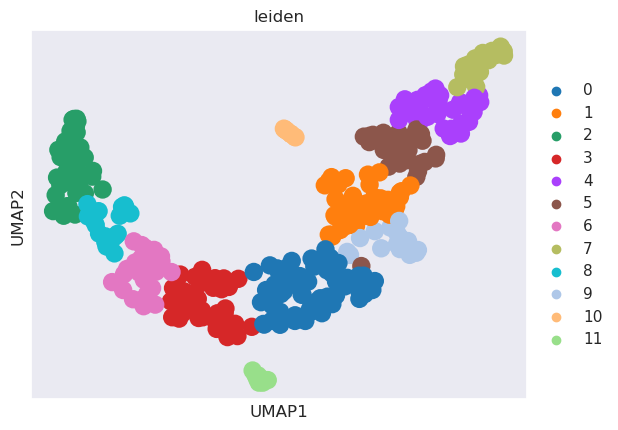

['2' '3' '11' '6' 'other' '9' '0' '1' '8' '5' '7' '4' '10']


In [3]:
# collapse the niches together
adata_C = ad.read_h5ad('adata_C_niche.h5ad')

dfs = []
for tma in adata_C.obs['batch'].unique():
    temp = adata_C[adata_C.obs['batch']==tma]
    niche_names = sorted(list(temp.obs['niche'].unique()), key=lambda x: (x=='other', int(x) if x != 'other' else float('inf')))
    niche_names_unique = [(tma + '_') + item if item != 'other' else item for item in niche_names]

    cts = []
    for n in niche_names:
        tempn = temp[temp.obs['niche']==n]
        cts.append(list(tempn.obs['cellType'].values))

    flattened_list = [item for sublist in cts for item in sublist]

    # Get the unique phenotypes
    unique_phenotypes = list(set(flattened_list))

    # Create a dictionary to store the counts
    phenotype_counts = {phenotype: [0] * len(niche_names) for phenotype in unique_phenotypes}

    # Count the occurrences of each phenotype for each group
    for i, group_list in enumerate(cts):
        for phenotype in group_list:
            phenotype_counts[phenotype][i] += 1

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(phenotype_counts, orient='index')
    df.columns = niche_names_unique

    # Normalize the counts for each group
    normalized_df = df.div(df.sum(axis=0), axis=1) * 100
    if 'other' in normalized_df.columns:
        normalized_df = normalized_df.drop('other', axis=1)
    dfs.append(normalized_df)

nicheprop_mat = pd.concat(dfs, axis=1, join='outer').fillna(0).T
print(nicheprop_mat)

ad_nicheprop = ad.AnnData(X=nicheprop_mat.values,
                          obs=pd.DataFrame(index=nicheprop_mat.index, data={'niche': nicheprop_mat.index}),
                          var=pd.DataFrame(index=nicheprop_mat.columns))

sc.pp.pca(ad_nicheprop, n_comps=7)
sc.pp.neighbors(ad_nicheprop, n_neighbors=10, n_pcs=7, use_rep='X_pca')
sc.tl.umap(ad_nicheprop)
sc.tl.leiden(ad_nicheprop, resolution=0.8)
sc.pl.umap(ad_nicheprop, color=['leiden'], size=700)

adata_C.obs['nicheCollapsed'] = ''
adata_C.obs['nicheCollapsed'] = adata_C.obs['nicheCollapsed'].astype(str)
for tma in adata_C.obs['batch'].unique():
    temp = adata_C[adata_C.obs['batch']==tma]
    for n in temp.obs['niche'].unique():
        if n != 'other':
            niche_code = tma+'_'+n
            new_niche = ad_nicheprop[ad_nicheprop.obs['niche']==niche_code].obs['leiden'].values[0]
            mask = (adata_C.obs['batch'] == tma) & (adata_C.obs['niche']==n)
            adata_C.obs.loc[mask, 'nicheCollapsed'] = new_niche
        else:
            mask = (adata_C.obs['batch'] == tma) & (adata_C.obs['niche']==n)
            adata_C.obs.loc[mask, 'nicheCollapsed'] = 'other'
                            
print(adata_C.obs['nicheCollapsed'].unique())

In [7]:
adata_C.write_h5ad('adata_C_FINAL.h5ad')

/tmp/ipykernel_2671773/1991207717.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


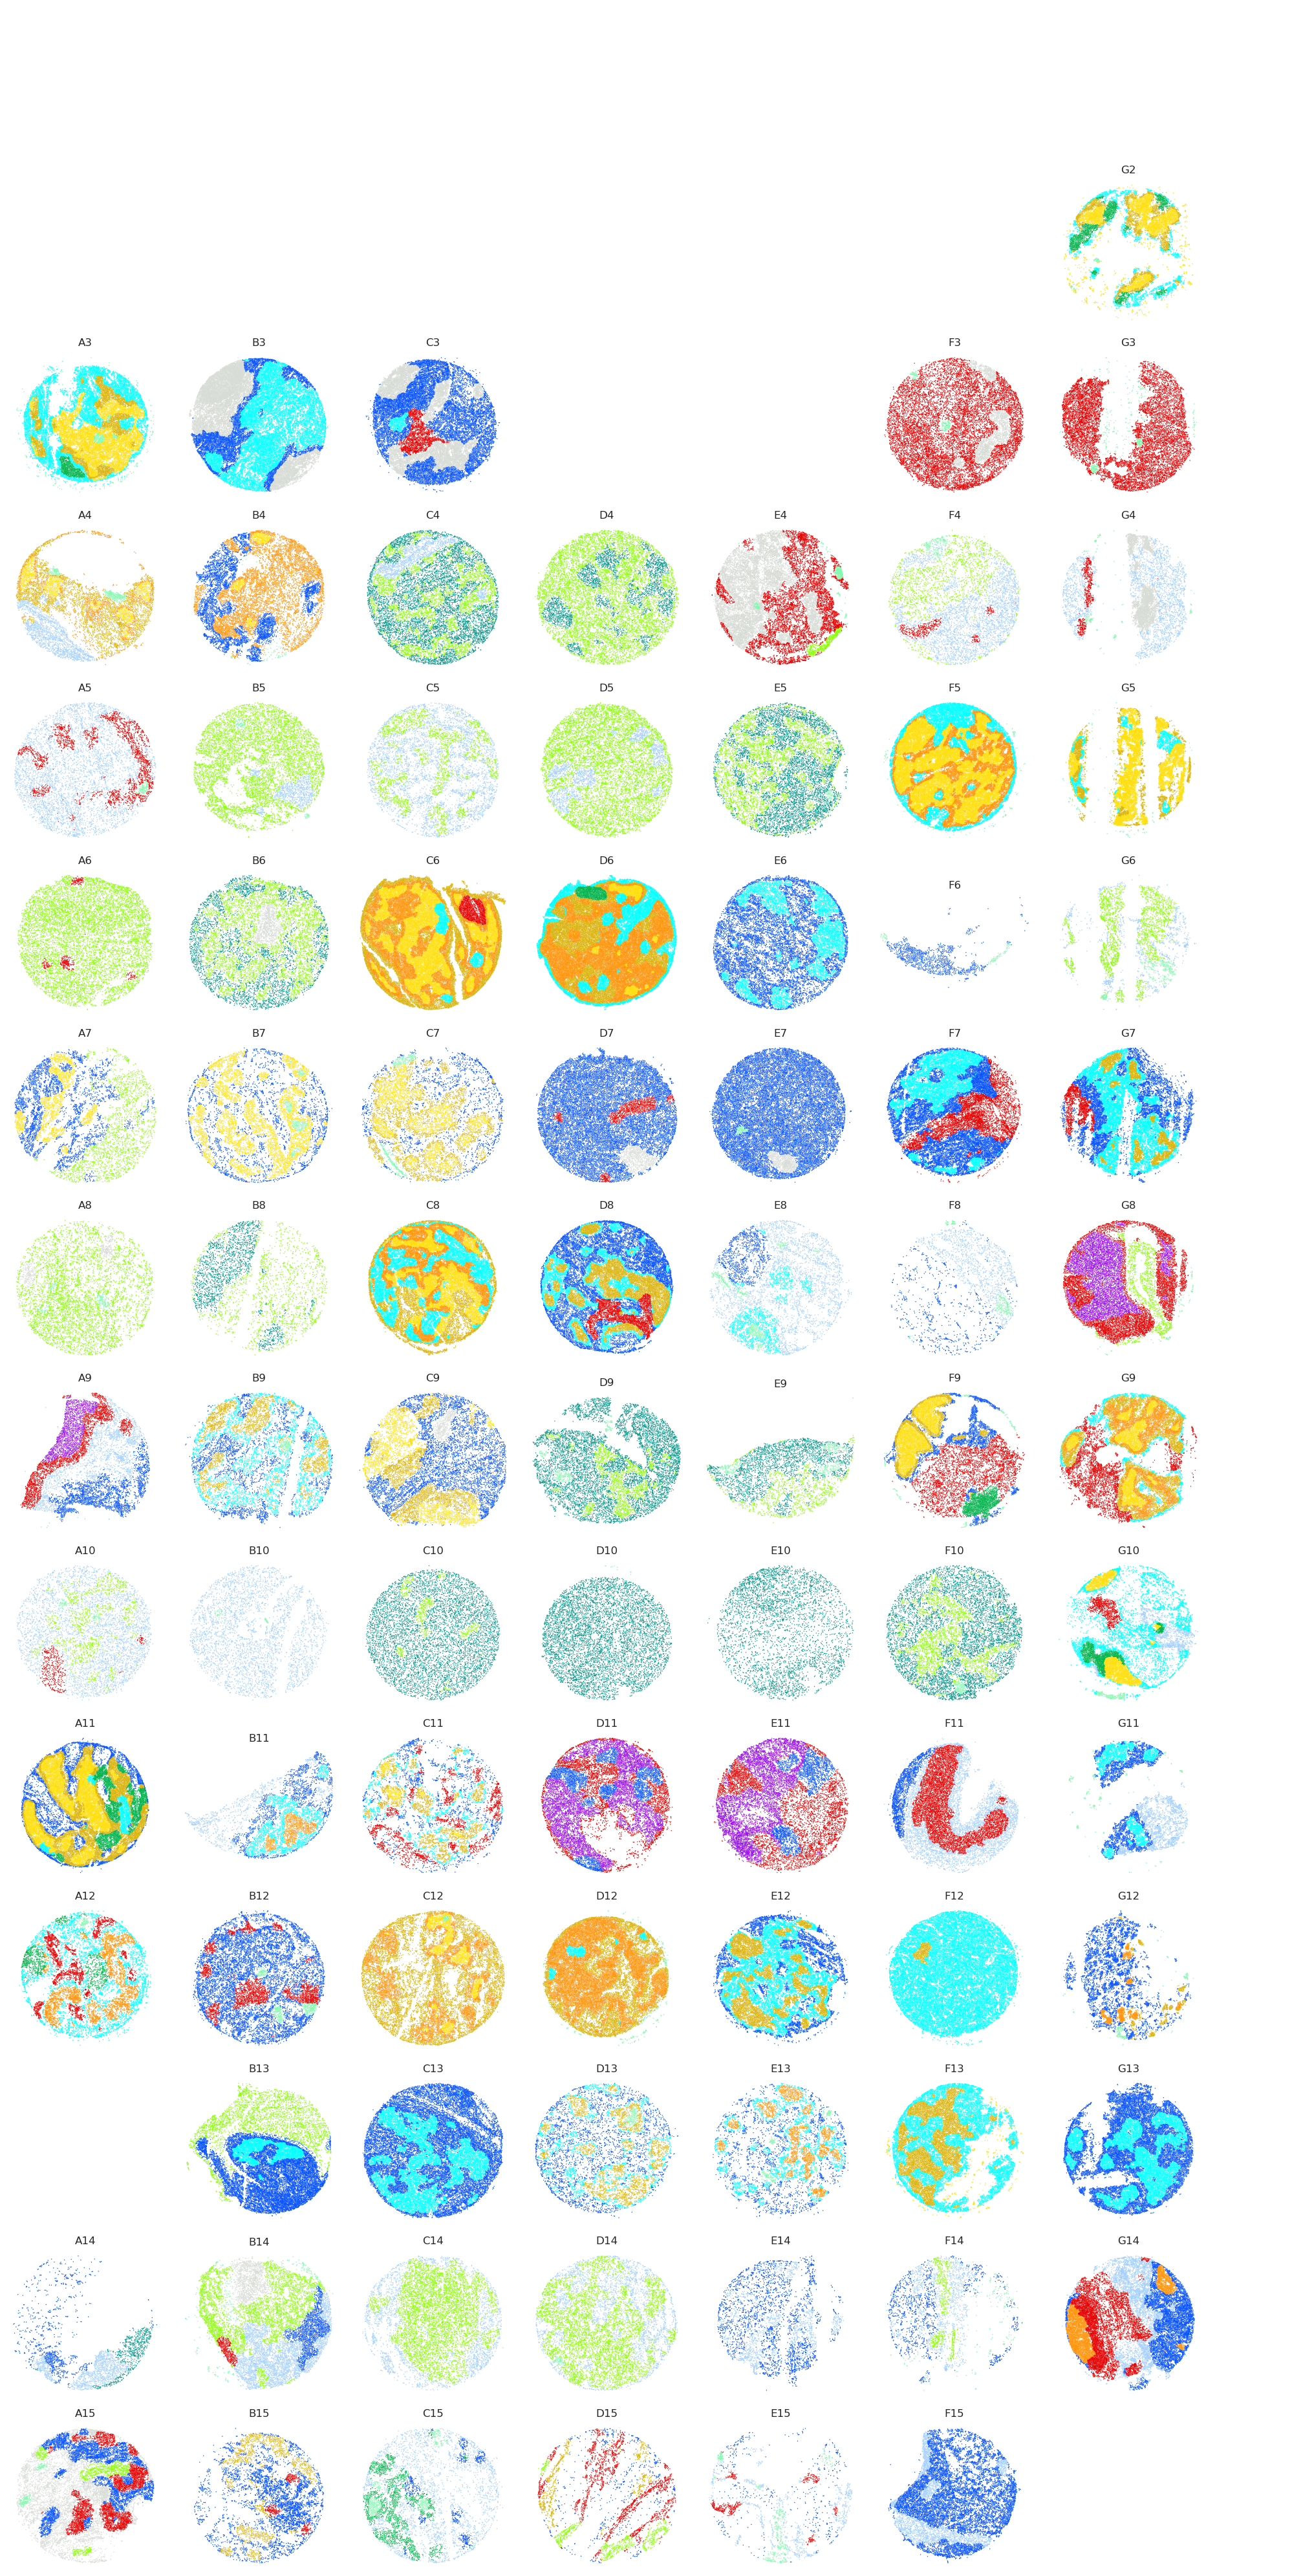

In [4]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

# Create a list of TMA positions
rows = range(1, 16)
cols = [chr(i) for i in range(ord('A'), ord('G') + 1)]
all_positions = [f'{c}{r}' for r in rows for c in cols]

# Get the unique TMAs from the data
TMAs = adata_C.obs['batch'].unique()

# Create the figure and axes
fig, axes = plt.subplots(nrows=15, ncols=7, figsize=(20, 40))

# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_C.obs['nicheCollapsed'])))
}

# Plot each TMA in the correct position, leaving blanks for missing TMAs
for pos, ax in zip(all_positions, axes.flat):
    if pos in TMAs:
        sc.pl.embedding(adata_C[adata_C.obs['batch'] == pos], basis='spatial', color='nicheCollapsed', ax=ax, show=False, size=4, palette=niche_to_color)
        ax.set_title(f'{pos}')
    else:
        ax.set_facecolor('white')  # Set blank background for missing TMAs
        ax.axis('off')  # Remove axes for missing TMAs
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    legend = ax.get_legend()
    if legend:
        legend.remove()

# Hide any remaining subplots that aren't used
for ax in axes.flat[len(all_positions):]:
    ax.axis('off')

# Create a new axis for the legend
legend_ax = fig.add_axes([0.96, 0.1, 0.04, 0.8])
legend_ax.axis('off')

# Check if any subplot has a legend
first_non_empty_plot = next((ax for ax in axes.flat if ax.get_legend()), None)
if first_non_empty_plot:
    legend_handles, legend_labels = first_non_empty_plot.get_legend_handles_labels()

    # Create the legend in the new axis
    legend_ax.legend(legend_handles, legend_labels, loc='center')

# Set the overall title and layout
# fig.suptitle('Neuro TMA Manual Cell Annotations', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

OrderedDict([('0', '#0652ff'), ('1', '#e50000'), ('2', '#fedf08'), ('3', '#00ffff'), ('4', '#89fe05'), ('5', '#a2cffe'), ('6', '#dbb40c'), ('7', '#029386'), ('8', '#ff9408'), ('9', '#d8dcd6'), ('10', '#9a0eea'), ('11', '#01b44c'), ('other', '#80f9ad')])


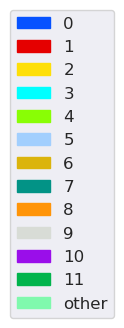

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import OrderedDict

# sort the dict
items = list(niche_to_color.items())
# Sort the list of tuples based on the keys
sorted_items = sorted(items, key=lambda x: (x[0] == 'other', x[0].isdigit(), int(x[0]) if x[0].isdigit() else float('inf')))
# Create a new OrderedDict from the sorted list of tuples
niche_to_color = OrderedDict(sorted_items)
print(niche_to_color)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(1, 2))

# Create a list of legend handles and labels
legend_handles = [mpatches.Patch(color=color, label=key) for key, color in niche_to_color.items()]
legend_labels = list(niche_to_color.keys())

# Plot the legend
ax.legend(handles=legend_handles, labels=legend_labels, loc='center', ncol=1, fontsize=12)

# Remove the axis
ax.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
niche_names = sorted(list(adata_C.obs['nicheCollapsed'].unique()), key=lambda x: (x=='other', int(x) if x != 'other' else float('inf')))
cts = []
for n in niche_names:
    tempn = adata_C[adata_C.obs['nicheCollapsed']==n]
    cts.append(list(tempn.obs['cellType'].values))
plot_stacked_bar(cts, niche_names, "All TMA")